In [323]:
# This script is designed to calculate the ballistic coefficient (alpha) and mass loss parameter (beta)
# for a population of imaginary meteoroids that are separated into different types based on density.
# The testable groups include: iron, pallasite, and stony achondrites; ordinary, enstatite, and carbonaceous chondrites; water ice.

import math
import random
import numpy as py
import pandas as pd
import matplotlib.pyplot as plt

In [381]:
# type = ["Iron achondrite", "Ordinary chondrite", "Enstatite chondrite", "Carbonaceous chondrite", "Water ice", "Methane ice"]
# density = [7500, 3320, 3635, 2783.3, 916.75, 475] # object densities, kg/m3
# Ca = [0.00000001, 0.000000023, 0.000000043, 0.000000043, 0.0000001, 0.0000001] # ablation coefficients, kg/J or s2/m2

type = ["CI chondrite", "CM chondrite", "CR chondrite", "CO chondrite", "CK chondrite", "CH chondrite", "CB chondrite"]
density = [2110, 2120, 3100, 2950, 3470, 3790, 5280]
colours = ["red", "orange", "yellow", "brown", "green", "magenta", "violet"] # colours used in final plot

In [382]:
# Define constants
D0 = 1.290 # critical density of exponential atmosphere, kg/m3
H0 = 7160 # critical height of exponential atmosphere, m
I0 = 1500 # energy of a zero-magnitude fireball selon Ceplecha et al (1998)
pi = 3.14159265358979
e = 2.718281828459045

In [383]:
# Generate a table to record outputs
df = pd.DataFrame(columns=['type', 'lna', 'lnasiny', 'lnb', 'ln2ab', 'Ve', 'Me', 'He', 'Se', 'diameter', 'Vt', 'Mt', 'Ht', 'slope', 'Pmax', 'logP', 'PF', 'logPF', 'colour'])
dict_list=[]

In [384]:
# Define the number of clones per meteoroid type
N = 1500

# Generate imaginary meteoroids
for x in range(len(type)):
    for i in range(N):
        colour = colours[x]
        # Cd = 1.
        Cd = random.uniform(0.8,1.2) # random drag coefficient
        Ca = random.uniform(0.00000002,0.000000045) # random ablation coefficient, kg/J
        mu = 2/3.
        # mu = random.uniform(0,0.667) # random shape factor
        
        Ve = random.uniform(11200,70000) # speed at entry, m/s, limits from Ceplecha et al (1998)
        # Ve = 12000
        # He = random.uniform(65000,100000) # random entry height, m, limits from GFO 10-year dataset
        He = 120000
        # Se = random.uniform(0.0007,10) # sectional area at entry, m2, excluding objects too small to be luminous selon Ceplecha et al (1998)
        Se = 0.00001*py.random.triangular(0, 1, 100000) # triangular frequency distribution; smaller objects are more common

        Sepi = Se/pi
        r = math.sqrt(Sepi) # entry radius, m, assuming SPHERICAL shape
        # r = math.sqrt(Se) # entry side length, m, assuming CUBIC shape
        diam = 2*r # entry diameter, m, assuming spherical shape
        Me = (4*pi*density[x]*r*r*r)/3 # entry mass, kg, assuming SPHERICAL shape
        # Me = density[x]*r*r*r # entry mass, kg, assuming CUBIC shape

        # slope = random.uniform(20, 70) # entry angle, degrees above horizontal, uniform distribution
        slope = py.random.normal(loc=45.73,scale=10) # entry angle, normal distribution according to DFN 10-year dataset
        # slope = 45
        gamma = (slope*2*pi)/360 # entry angle, radians above horizontal
        Zr = (pi/2)-gamma # entry angle, radians from vertical
        
        singamma = math.sin(gamma)
        alpha = Cd*D0*H0*Se/(2*Me*singamma)
        beta = (1-mu)*(Ca)*Ve*Ve*0.5
        lna = math.log(alpha) # log ballistic coefficient
        lnasiny = math.log(alpha*singamma) # log ballistic coefficient with entry angle dependency removed
        lnb = math.log(beta) # log mass loss parameter         
        ab = alpha*beta
        ln2ab = math.log(2*ab)

        # Compute terminal speed, mass and height
        dt = 0.01 # time step, s
        V = Ve
        M = Me
        S = Se
        H = He
        t = 0
        Pd_all = []
        
        for i in range(4000):
            t = t + dt # time, s
            Pa = 111135*e**(-0.000146*H) #atmospheric pressure, Pa
            Da = 1.5022*e**(-0.000144*H) #atmospheric density, kg/m3
            g = 9.8055-(0.000003*H) # gravitational field strength, m/s2

            Pd = (Da*V*V)/1000000 # dynamic pressure, MPa
            Pd_all.append(Pd)
            a = (g*math.cos(Zr))-(Cd*Pd*S/M)
            Vf = V + a*dt # updated speed
            Hf = H - dt*Vf*math.sin(gamma) # updated height
            Mf = M - dt*Da*Vf*Vf*Vf*S*(Ca) # updated mass
            vol = Mf/density[x]
            r = ((3*vol)/(4*pi))**(1/3)
            Sf = pi*r*r # updated sectional area, assuming SPHERICAL shape
            # r = vol**(1/3)
            # Sf = r*r # updated sectional area, assuming CUBIC shape
            
            if Mf<=0:
                M=0
                break
            elif Hf<=0:
                H=0
                break
            else:
                V = Vf
                M = Mf
                H = Hf
                S = Sf
                continue
        
        Pmax = max(Pd_all) # maximum dynamic pressure, MPa
        logP = math.log(Pmax)
        PF = (100*Pmax*((Me)**(-1/3))*((Ve/1000)**(-3/2)))/math.cos(Zr) # Pressure factor selon Borovicka et al (2022b)
        logPF = math.log10(PF)
        

        # Update the table
        row=[type[x], lna, lnasiny, lnb, ln2ab, Ve, Me, He, Se, diam, V, M, H, slope, Pmax, logP, PF, logPF, colour]
        df.loc[len(df)] = row

df = df.reset_index(drop=True)
print(df)

               type       lna   lnasiny       lnb     ln2ab            Ve  \
0      CI chondrite  1.659629  1.425161  1.710708  4.063484  38431.182694   
1      CI chondrite  2.375149  1.908962  2.067126  5.135422  45699.276134   
2      CI chondrite  3.053779  2.162471  3.038097  6.785023  65201.740344   
3      CI chondrite  2.577821  1.654053  2.489796  5.760764  50853.175592   
4      CI chondrite  2.864347  2.524098  2.173793  5.731286  38128.732668   
...             ...       ...       ...       ...       ...           ...   
10495  CB chondrite  1.271538  1.090062 -0.530409  1.434276  12382.367939   
10496  CB chondrite  1.738404  1.338280  2.874345  5.305896  54993.753642   
10497  CB chondrite  1.174020  0.973611  2.574378  4.441545  54627.018420   
10498  CB chondrite  1.034888  0.690686  1.493320  3.221355  24863.973739   
10499  CB chondrite  0.865405  0.381687  2.957527  4.516079  53617.051872   

                Me      He        Se  diameter            Vt   Mt  \
0     

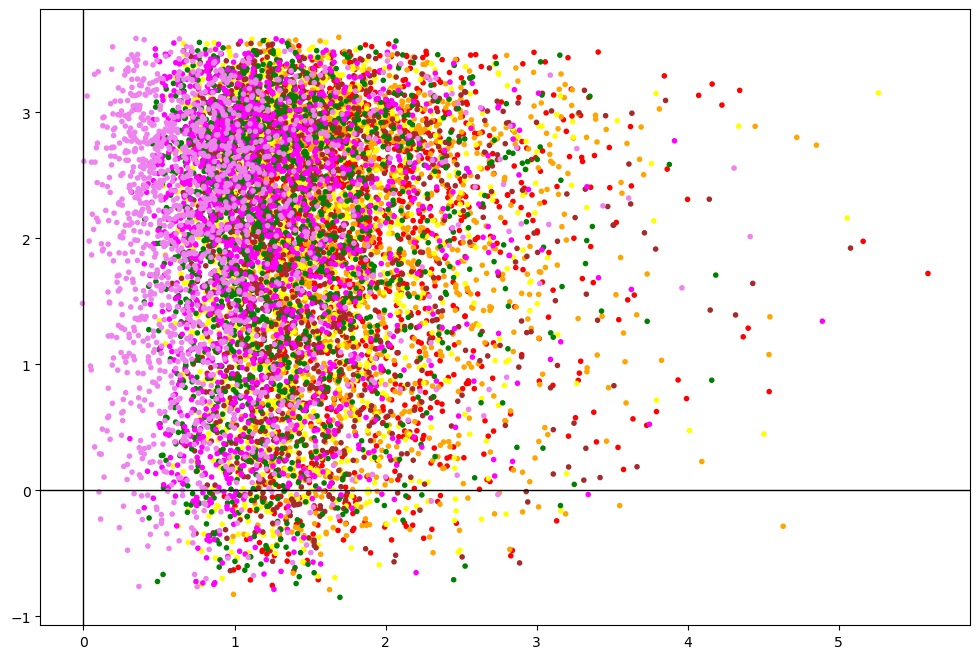

In [385]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(df["lnasiny"], df["lnb"], label=type, color=df["colour"], marker='.')
plt.axvline(x=0, lw=1, color='black')
plt.axhline(y=0, lw=1, color='black')
plt.show()

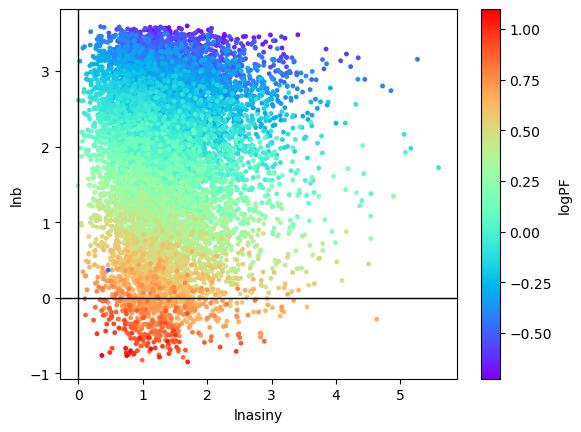

In [396]:
# df.plot.scatter(x="lnasiny", y="lnb", s=6, c="logPf") # change c to any output parameter
df.plot.scatter(x="lnasiny", y="lnb", s=6, c="logPF", cmap='rainbow')
plt.axvline(x=0, lw=1, color='black')
plt.axhline(y=0, lw=1, color='black')
plt.show()

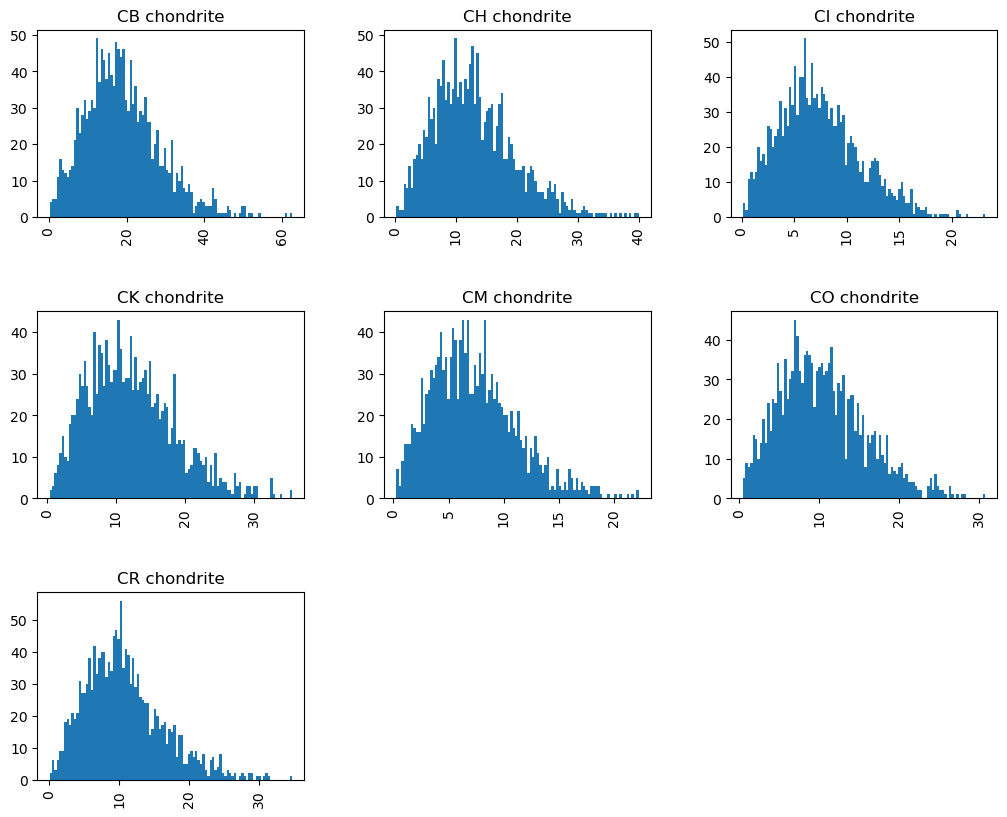

In [387]:
# Plot max. dynamic pressure histograms for each type
histo = df.hist(column='Pmax', by='type', bins=100, figsize=(12,10))

In [388]:
# Export the table
# change 'meow' to the file name you prefer
df.to_csv('meow.csv', encoding='utf-8', index=False)

In [276]:
# Created by T.W.C. Stevenson, June 2024
# References:
# Ceplecha et al (1998) 'Meteor phenomena and bodies'
# Gritsevich (2009) 'Determination of parameters of meteor bodies based on flight observational data'
# Wheeler et al (2018) 'Atmospheric energy deposition modeling and inference for varied meteoroid structures'
# Sansom et al (2019) 'Determining fireball fates using the α-β criterion'
# Borovicka et al (2022a) 'Description of the [European Fireball] network, data reduction procedures, and the catalog'
# Borovicka et al (2022b) 'Analysis of orbital and physical properties of centimeter-sized meteoroids'

# Good luck with your study!